In [34]:
## Load the relevant libraries

import numpy as np              
import pandas as pd               
import matplotlib.pyplot as plt   
import seaborn as sns             

## jupyter에서 그래픽출력 활성화
%matplotlib inline
## 트리맵 그리기                 
import squarify                   

from sklearn.preprocessing import StandardScaler ## 표준화
from sklearn.preprocessing import MinMaxScaler ## min-max 정규화
from sklearn.cluster import KMeans ## kmeans 군집화
from sklearn.metrics import silhouette_score ## 실루엣 계수 계산 - 클러스터링 평가 척도
import scipy.cluster.hierarchy as shc ## 계층적 군집화 (거리 matrix 생성)
from sklearn.cluster import AgglomerativeClustering ## 주어진 거리 matrix에 대해 군집화

import warnings                    
warnings.filterwarnings('ignore')

In [35]:
df =pd.read_csv('C:\kaggle\merged_project\Mall_Customers.csv')
print(df.head(5))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [36]:
# \033[94m 색상
# print(df.shape) = (200, 5) 행, 열
print(f'\033[94mNumber of records (rows) in the dataset are: {df.shape[0]}')
print(f'\033[94mNumber of records (columns) in the dataset are: {df.shape[1]}')
# 중복된 행 개수
print(f'\033[94mNumber of duplicate entries in the dataset are: {df.duplicated().sum()}')
# 결측값 개수
print(f'\033[94mNumber missing values in the dataset are: {sum(df.isna().sum())}')

Number of records (rows) in the dataset are: 200
Number of records (columns) in the dataset are: 5
Number of duplicate entries in the dataset are: 0
Number missing values in the dataset are: 0


In [37]:
print('\n')
print(df.info()) ## 데이터개요 (열, 비어있지 않은 값의 수, 데이터유형, 메모리 사용량)
# 기술 통계 (숫자 열의 개수, 고유한 값, 가장빈번한 값, 빈도, 평균, 표준편차, 최소값, 백분위수, 최대값)
print('---'*25, '\n', df.describe(include='all').T, '---'*25,'\n')
# unique



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
--------------------------------------------------------------------------- 
                         count unique     top freq   mean        std   min  \
CustomerID              200.0    NaN     NaN  NaN  100.5  57.879185   1.0   
Gender                    200      2  Female  112    NaN        NaN   NaN   
Age                     200.0    NaN     NaN  NaN  38.85  13.969007  18.0   
Annual Income (k$)      200.0    NaN     NaN  NaN  60.56  26.264721  15.0   
Spending Sco

In [38]:
#inplace=True 원본 df 직접 수정
df.rename(columns={'Annual Income (k$)': 'Income(k$/yr)','Spending Score (1-100)':'SpendScore(1-100)'}, inplace=True)

#df= df.drop(columns=['CustomerID'])

print(df.columns)

Index(['CustomerID', 'Gender', 'Age', 'Income(k$/yr)', 'SpendScore(1-100)'], dtype='object')


In [67]:
df=df.drop(columns=['CustomerID'])
print(df.columns)

Index(['Gender', 'Age', 'Income(k$/yr)', 'SpendScore(1-100)'], dtype='object')


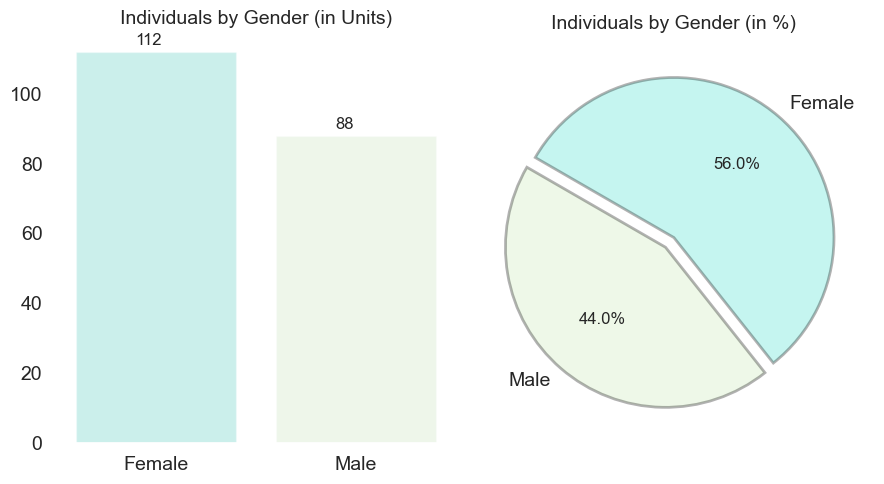

In [39]:
## Gender feature analysis
# Seaborn 라이브러리 스타일 설정 (배경색상: 투명, 축 그리드: 비활성화, 축 레이블크기 설정, 그림 자동 조절 ), 딕셔너리 생성
sns.set(rc={'axes.facecolor':'none', 'axes.grid':False, 'xtick.labelsize':14, 'ytick.labelsize':14, 'figure.autolayout':True})

# matplotlib subplot 생성 가로 9인치, 세로 5인치
plt.subplots(figsize=(9,5))

# Seaborn 팔레트 설정(젠더 특성 색상)
my_pal = ('#40E0D0', '#c7e9b4')
# Seaborn 'explode' 매개변수 설정, 조각을 얼마나 띄울지 설정
# male, female / female에 해당하는 부분을 떼어내서 표시 -> 시각적으로 강조
my_xpl = [0.0, 0.08]

# 가로 눈금과 레이블 제거
plt.xticks([])
# 세로 눈금과 레이블 제거
plt.yticks([])

## Total Individuals by Gender (in units)
# 전체 그림 영역을 둘로 나누기 (1행, 2열, 첫번째 위치에 서브플롯 생성)
plt.subplot(1,2,1)
plt.title('Individuals by Gender (in Units)',fontsize=14)

# countplot - 성별에 따른 객체 수 시각화
# df['Gender'].value_counts() - 각 값의 빈도수 체크 (series)
# df['Gender'].value_counts().index - 각 빈도수 결과에서 인덱스 추출 - 각 성별값 추출/ 큰값부터 정렬
# alpha - 막대 투명도 (0- 완전투명)
ax = sns.countplot(x="Gender",data=df, palette=my_pal, order=df['Gender'].value_counts().index, alpha=0.3)
# ax.patches - 막대 플롯에 있는 각 막대
for p in ax.patches:
    # ax.annotate(text, xy)
    # ({:.0f}'.format(p.get_height()) -막대 높이를 정수형식(.0f)으로 포맷 -> 주석에 표시할 텍스트
    # (p.get_x()+0.30, p.get_height()+2) - 주석 표시될 위치 지정 -> 주석을 추가할 위치를 나타내는 튜플(x,y)
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+2))

    
plt.xlabel(None)
plt.ylabel(None)


## Total individuals by Gender (in %)
plt.subplot(1,2,2)
plt.title("Individuals by Gender (in %)",fontsize=14)
# 파이차트, 색상, 범례표시안함, 떼어내서 표시, y축 비활성화, 파이차트 시게방향, 시작각도, (투명도, 테두리색상, 두께, 부드러운 효과), 퍼센트 값 소수점 1자리)
# wedgeprops - 부채꼴(wedge) 속성 지정
df['Gender'].value_counts().plot(kind='pie', colors=my_pal, legend=None, explode=my_xpl, ylabel='',counterclock=False, startangle=150, wedgeprops={'alpha':0.3,  'edgecolor': 'black', 'linewidth':2, 'antialiased':True}, autopct='%1.1f%%')

plt.show()





<Axes: title={'center': 'Income vs Spending Score: Scatterplot'}, xlabel='Income(k$/yr)', ylabel='SpendScore(1-100)'>

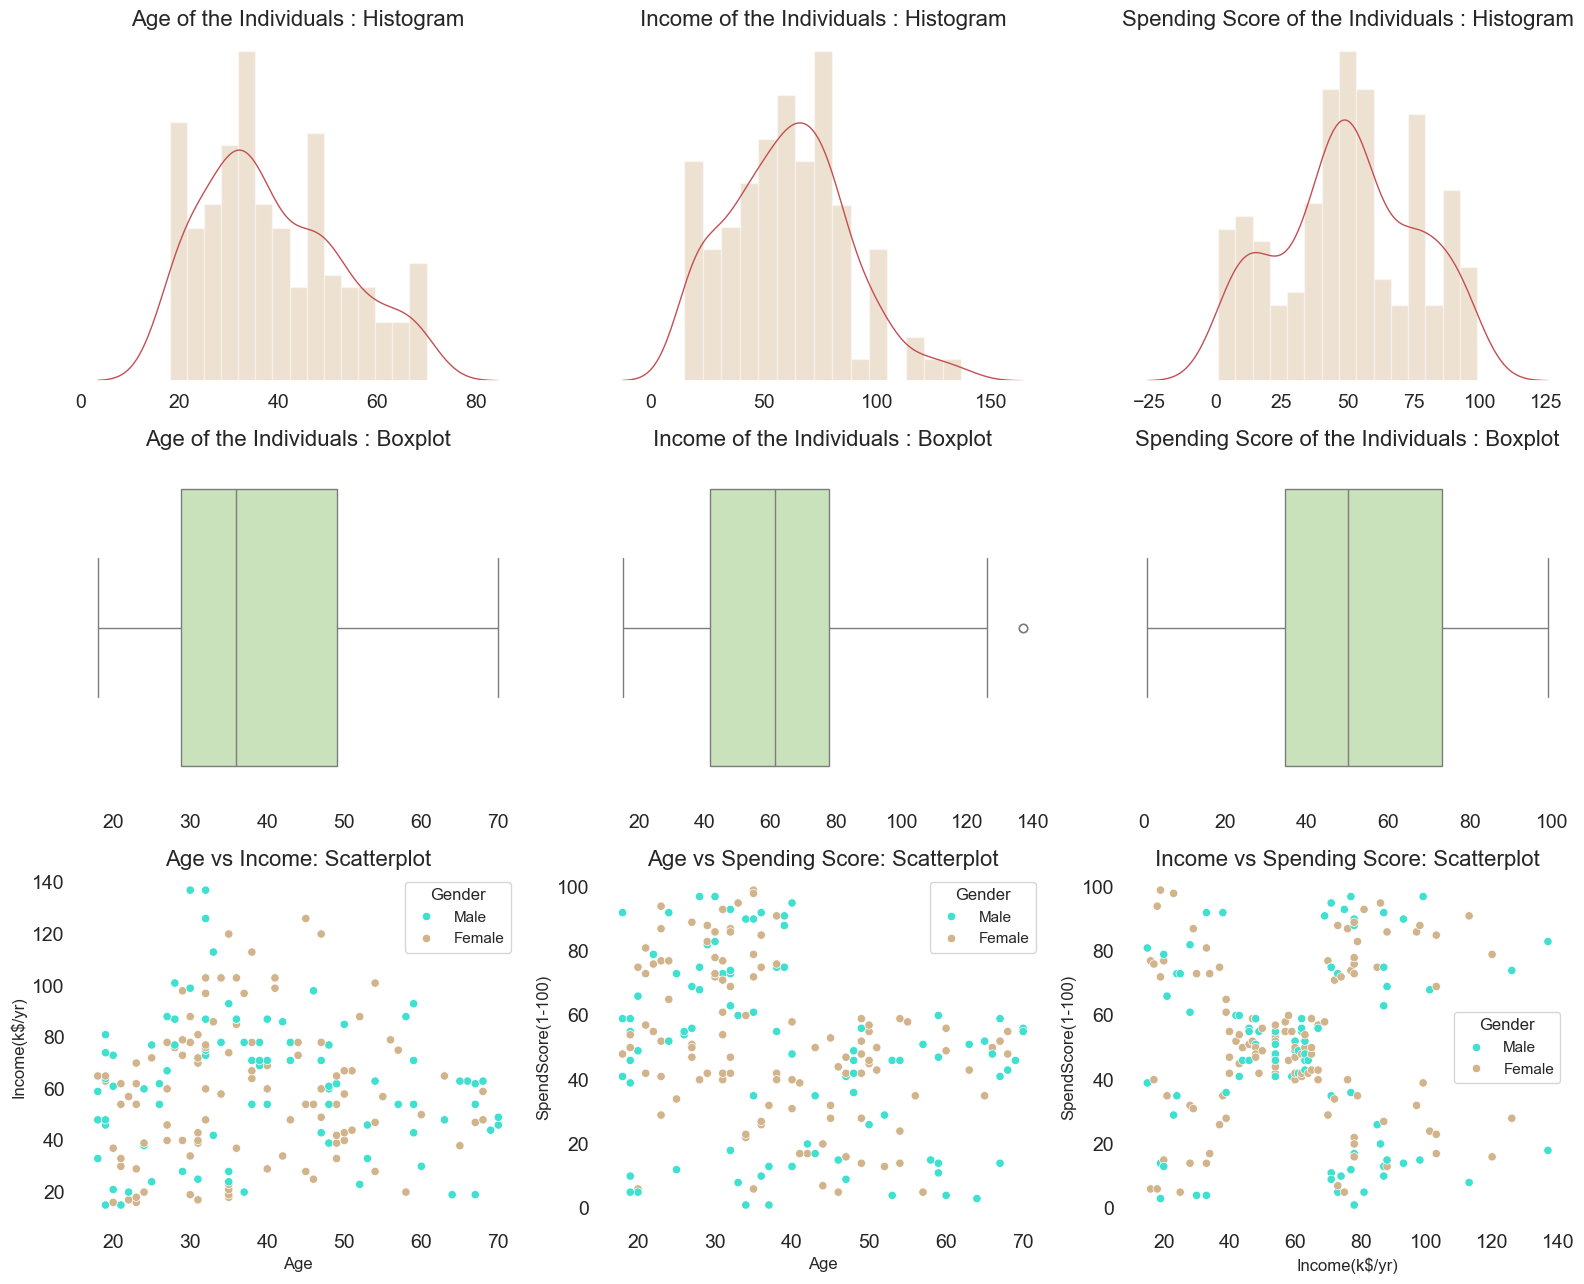

In [40]:
## Let's understand the patterns and trends in the numerical variables
## Age, Income(k$/yr), and SpendScore(1-100) are the 3 numerical variables we have here

plt.subplots(figsize=(16,13))
plt.xticks([])
plt.yticks([])

plt.subplot(3,3,1)
plt.title('Age of the Individuals : Histogram', fontsize=16)
# distplot - 히스토그램 그리기/ bins - 막대의 개수/ kde_kws - 커널 밀도 추정 그래프(선그래프)
sns.distplot(df['Age'],color='#D2B48C', bins=15, kde_kws={'linewidth':1,'color':'r'})
plt.ylabel(None)
plt.yticks([])
plt.xlabel(None)

plt.subplot(3,3,2)
plt.title('Income of the Individuals : Histogram', fontsize=16)
sns.distplot(df['Income(k$/yr)'],color='#D2B48C', bins=15, kde_kws={'linewidth':1,'color':'r'})
plt.ylabel(None)
plt.yticks([])
plt.xlabel(None)

plt.subplot(3,3,3)
plt.title('Spending Score of the Individuals : Histogram', fontsize=16)
sns.distplot(df['SpendScore(1-100)'],color='#D2B48C', bins=15, kde_kws={'linewidth':1,'color':'r'})
plt.ylabel(None)
plt.yticks([])
plt.xlabel(None)

plt.subplot(3,3,4)
plt.title('Age of the Individuals : Boxplot', fontsize=16)
# 중앙값, 이상치 확인 /orient = 그래프 방향 (h: 가로)
sns.boxplot(df['Age'],color='#c7e9b4', orient="h")
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(3,3,5)
plt.title('Income of the Individuals : Boxplot', fontsize=16)
sns.boxplot(df['Income(k$/yr)'],color='#c7e9b4', orient="h")
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(3,3,6)
plt.title('Spending Score of the Individuals : Boxplot', fontsize=16)
sns.boxplot(df['SpendScore(1-100)'],color='#c7e9b4', orient="h")
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(3,3,7)
plt.title('Age vs Income: Scatterplot', fontsize=16)
# hue 범주형 데이터 구분, 색상 구분 (성별)
sns.scatterplot(data=df, x='Age',y='Income(k$/yr)', hue='Gender', palette=('#40E0D0','#D2B48C'), alpha=1)

plt.subplot(3,3,8)
plt.title('Age vs Spending Score: Scatterplot', fontsize=16)
# hue 범주형 데이터 구분, 색상 구분 (성별)
sns.scatterplot(data=df, x='Age',y='SpendScore(1-100)', hue='Gender', palette=('#40E0D0','#D2B48C'), alpha=1)

plt.subplot(3,3,9)
plt.title('Income vs Spending Score: Scatterplot', fontsize=16)
# hue 범주형 데이터 구분, 색상 구분 (성별)
sns.scatterplot(data=df, x='Income(k$/yr)',y='SpendScore(1-100)', hue='Gender', palette=('#40E0D0','#D2B48C'), alpha=1)


In [41]:
# analysis by creating a subset dataframe

X =df[['Income(k$/yr)', 'SpendScore(1-100)']].copy()
print(X.head(5))

   Income(k$/yr)  SpendScore(1-100)
0             15                 39
1             15                 81
2             16                  6
3             16                 77
4             17                 40


In [42]:
# scale the features (표준화, 평균 0)

scaler= StandardScaler()
# X - 원래 특성 행렬, fit_transform - 특성 표준화
X_kmeans= scaler.fit_transform(X)
print(X_kmeans)

[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]
 [-1.66266033  1.00159627]
 [-1.62449091 -1.71591298]
 [-1.62449091  1.70038436]
 [-1.58632148 -1.83237767]
 [-1.58632148  0.84631002]
 [-1.58632148 -1.4053405 ]
 [-1.58632148  1.89449216]
 [-1.54815205 -1.36651894]
 [-1.54815205  1.04041783]
 [-1.54815205 -1.44416206]
 [-1.54815205  1.11806095]
 [-1.50998262 -0.59008772]
 [-1.50998262  0.61338066]
 [-1.43364376 -0.82301709]
 [-1.43364376  1.8556706 ]
 [-1.39547433 -0.59008772]
 [-1.39547433  0.88513158]
 [-1.3573049  -1.75473454]
 [-1.3573049   0.88513158]
 [-1.24279661 -1.4053405 ]
 [-1.24279661  1.23452563]
 [-1.24279661 -0.7065524 ]
 [-1.24279661  0.41927286]
 [-1.20462718 -0.74537397]
 [-1.20462718  1.42863343]
 [-1.16645776 -1.7935561 ]
 [-1.16645776  0.88513158]
 [-1.05194947 -1.7935561 ]
 [-1.05194947  1.62274124]
 [-1.05194947 -1.4053405 ]
 [-1.05194947  1.19570407]
 [-1.01378004 -1.28887582]
 

In [43]:
# Apply the elbow method to determine the number of clusters
# K-means 군집화 알고리즘에서 cluster 개수 결정하기 위해 elbow method 적용
# cluster 개수에 따른 within-cluster sum of squares(WCSS) 변화 -> 최적의 개수 결정

# wcss : cluster 내의 data point와 cluster 중심간의 거리의 제곱의 합, 작을수록 응집도 높음
wcss=[]

# cluster 개수 1~10까지 변경
for cluster in range(1,11):
    # 현재 cluster 개수로 초기화
    # random_state -> 호출할 때마다 동일한 dataset을 만들기 위함, 어떤 숫자는 동일하면 상관 x
    # init='k-means++' -> 초기 cluster 중심 잘 분포시킬 수 있음
    Kmeans= KMeans(n_clusters=cluster, init='k-means++', random_state=42)
    # fit - clustering 알고리즘 학습/ X_kmeans- 표준화한 행렬
    Kmeans.fit(X_kmeans)
    #inertia - 학습결과 wcss값
    wcss.append(Kmeans.inertia_ )

wcss


[400.0,
 269.69101219276394,
 157.70400815035947,
 108.92131661364357,
 65.56840815571681,
 55.057348270386,
 44.86475569922557,
 37.228187677585886,
 32.392267630331176,
 29.981897788243693]

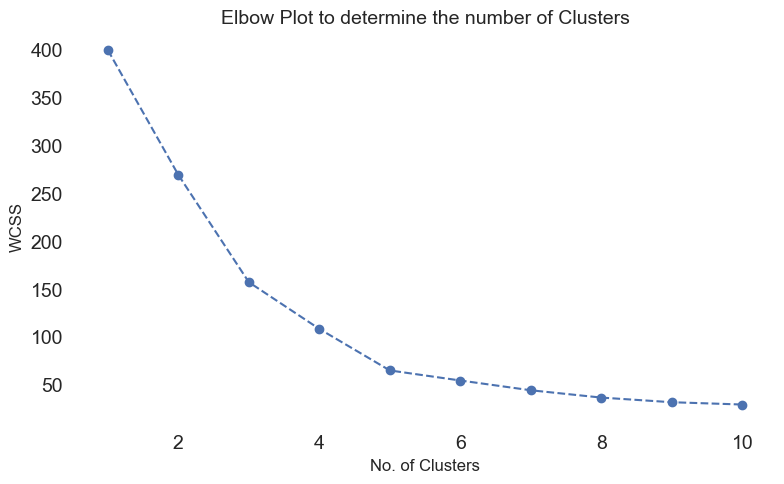

In [44]:
## plotting elbow plot to determine ideal clusters' number

plt.figure(figsize=(8,5))

plt.plot(range(1,11), wcss, 'o--')
plt.title('Elbow Plot to determine the number of Clusters',fontsize=14)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')

plt.show()

In [45]:
## Identifying the Knee in the Elbow Plot with KneeLocator function
from kneed import KneeLocator

In [46]:
## knee 찾기
# curve='convex' - 곡선 유형
k1=KneeLocator(range(1,11), wcss, curve='convex', direction="decreasing")
print('The Knee located at figure:', k1.elbow)

The Knee located at figure: 5


In [54]:
## 클러스터 수 결정을 위한 Silhouette method 적용

silhouette_coef=[]

for cluster in range(2,11): # 최소 2개 이상의 클러스터가 의미/ 2~10까지 변화시키면서 반복
    kmeans = KMeans(n_clusters=cluster, init='k-means++', random_state =1)
    # fit() 머신러닝 모델 학습 - 주어진 데이터 사용하여 모델 학습/ 표준화한 행렬 X_kmeans
    kmeans.fit(X_kmeans) 
    # kmeans.labels_ -> 각 데이터 포인트에 할당된 label
    # Silhouette Coefficient = (b - a) / max(a, b)
    score= silhouette_score(X_kmeans, kmeans.labels_)
    silhouette_coef.append(score)

silhouette_coef

[0.29512063001659344,
 0.46658474419000145,
 0.4939069237513199,
 0.5546571631111091,
 0.5398800926790663,
 0.5256026931619203,
 0.4541279523637649,
 0.4566624374485964,
 0.4487229314026326]

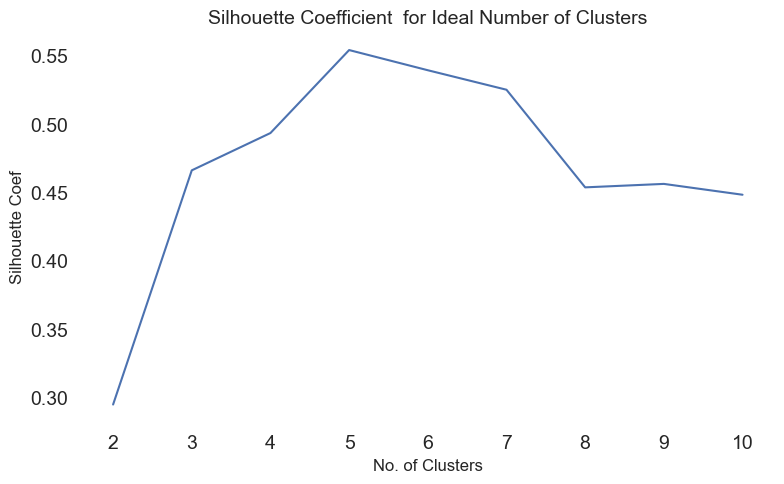

In [55]:
## 실루엣 상관계수 데이터 (plot the Silhouette Coefficient data)

plt.figure(figsize=(8,5))
plt.plot(range(2,11), silhouette_coef)
plt.xticks(range(2,11))
plt.title('Silhouette Coefficient  for Ideal Number of Clusters', fontsize=14)
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Coef')
plt.show()

### 5일때 실루엣 계수의 값이 젤 높기 때문에 최적의 클러스터 개수로 선택

In [58]:
## model fitting with 5 clusters
# 5개 클러스터 모델 생성
clusters = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans= clusters.fit_predict(X_kmeans)
# 데이터 포인트가 어느 클래스터에 속하는 지
y_kmeans

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 0,
       4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 1, 3, 1,
       0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1])

In [68]:
## cluster 열 추가한 새로운 데이터 프레임 생성
df_Kmeans = df.copy()
df_Kmeans['Cluster']=y_kmeans
print(df_Kmeans.head(5))

   Gender  Age  Income(k$/yr)  SpendScore(1-100)  Cluster
0    Male   19             15                 39        4
1    Male   21             15                 81        3
2  Female   20             16                  6        4
3  Female   23             16                 77        3
4  Female   31             17                 40        4


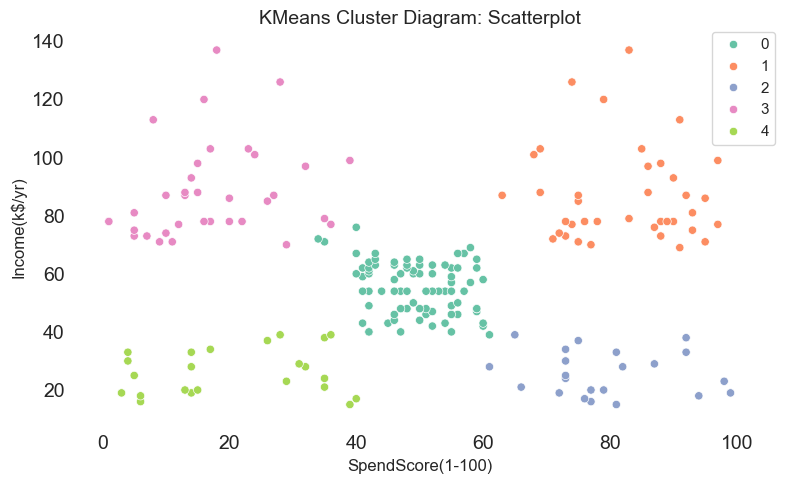

In [61]:
## 산점도를 이용하여 클러스터 개수와 함께 새로운 데이터 프레임 시각화

plt.figure(figsize=(8,5))
plt.title('KMeans Cluster Diagram: Scatterplot', fontsize=14)
# hue - 데이터를 색상으로 구분할 열
sns.scatterplot(data=df_Kmeans, x='SpendScore(1-100)', y='Income(k$/yr)', hue='Cluster', palette="Set2")
plt.legend(bbox_to_anchor=(1.02,1),loc='best', borderaxespad=0)
plt.show()

In [62]:
## Hierarchial analysis by normalizing data
## building dataframe for analysis
# 값을 0~1 범위로 정규화
norm = MinMaxScaler()

##df[['Income(k$/yr)', 'SpendScore(1-100)']].copy()
X_Hierar = norm.fit_transform(X)
X_Hierar=pd.DataFrame(X_Hierar, columns=X.columns)
print(X_Hierar.head(5))

   Income(k$/yr)  SpendScore(1-100)
0       0.000000           0.387755
1       0.000000           0.816327
2       0.008197           0.051020
3       0.008197           0.775510
4       0.016393           0.397959


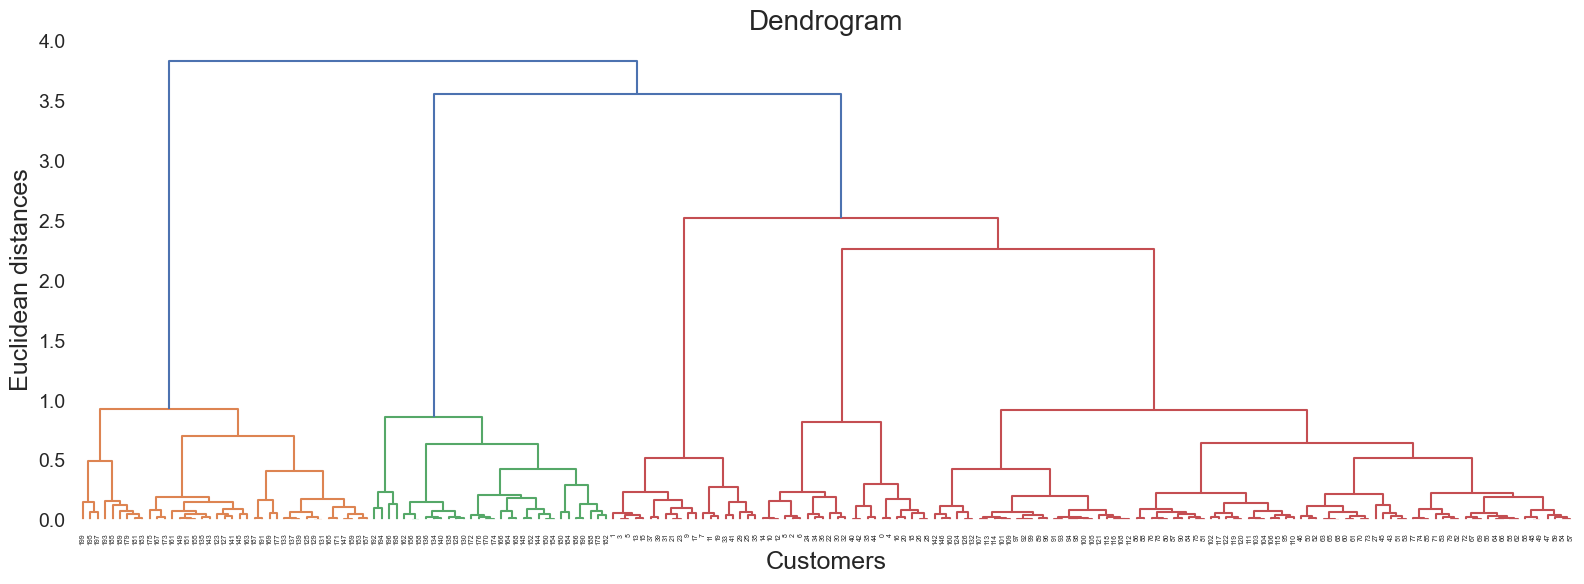

In [63]:
 ## build dendrogram to find out the optimal number of clusters

plt.figure(figsize=(16,6))
# linkage - 군집간의 거리 계산, ward - 군집간의 분산최소화
dendrogram= shc.dendrogram(shc.linkage(X_Hierar, method='ward'))
plt.title('Dendrogram', fontsize=20)
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Euclidean distances', fontsize=18)
plt.show()

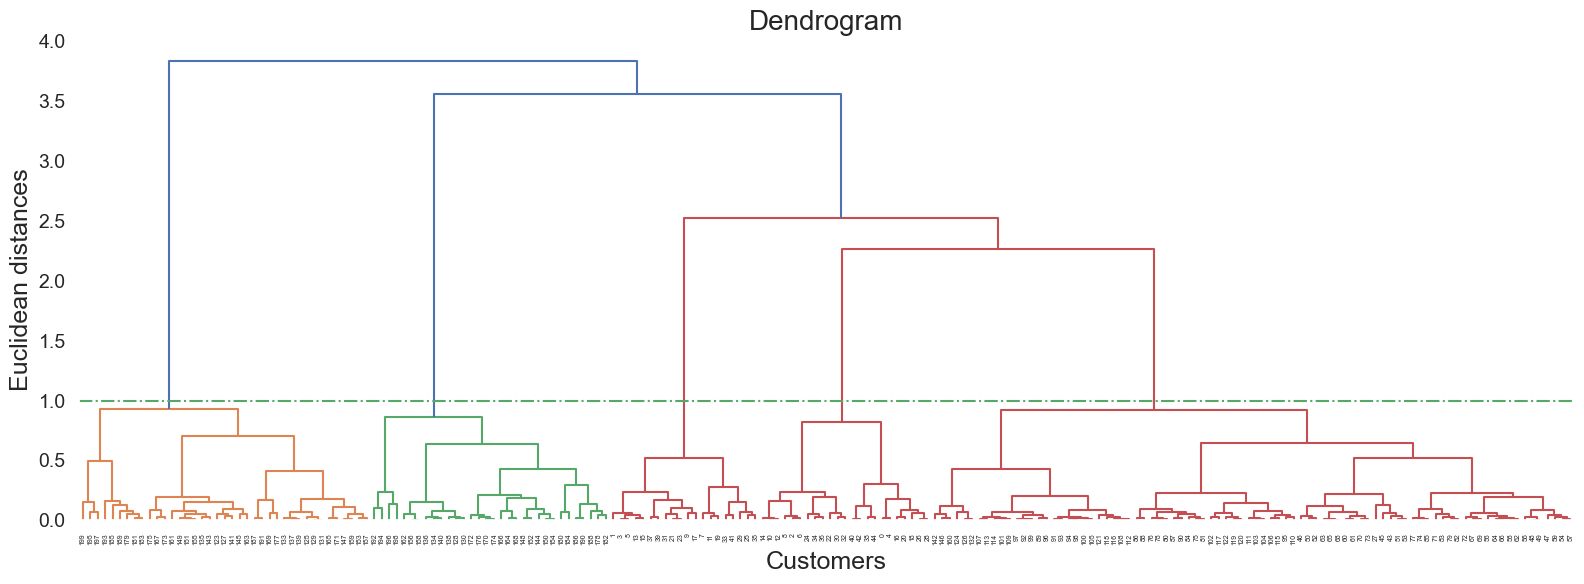

In [64]:
## draw the threshold level to identify the ideal number of cluster
## dendrogram에 임게 수준을 표시하여 이상적인 클러스터 개수를 확인
plt.figure(figsize=(16,6))
dendrogram=shc.dendrogram(shc.linkage(X_Hierar, method='ward'))
# axhline - 수평선 추가
plt.axhline(y=1, color='g',linestyle='dashdot')

plt.title('Dendrogram', fontsize=20)
plt.xlabel('Customers', fontsize=18)
plt.ylabel('Euclidean distances', fontsize=18)
plt.show()

In [65]:
## model fitting with 5 clusters
# 군집개수 5, 유클리디안 거리 측정, 분산 최소화// agglomerative(bottom-up)
clusters = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
# clustering 하고 각 포인트에 대한 레이블 반환
y_kmeans=clusters.fit_predict(X_Hierar)
y_kmeans

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 1, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0,
       1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0], dtype=int64)

In [69]:
# Create new dataframe append cluster column

df_Hierar=df.copy()
df_Hierar['Cluster']=y_kmeans
print(df_Hierar.head(5))

   Gender  Age  Income(k$/yr)  SpendScore(1-100)  Cluster
0    Male   19             15                 39        4
1    Male   21             15                 81        3
2  Female   20             16                  6        4
3  Female   23             16                 77        3
4  Female   31             17                 40        4


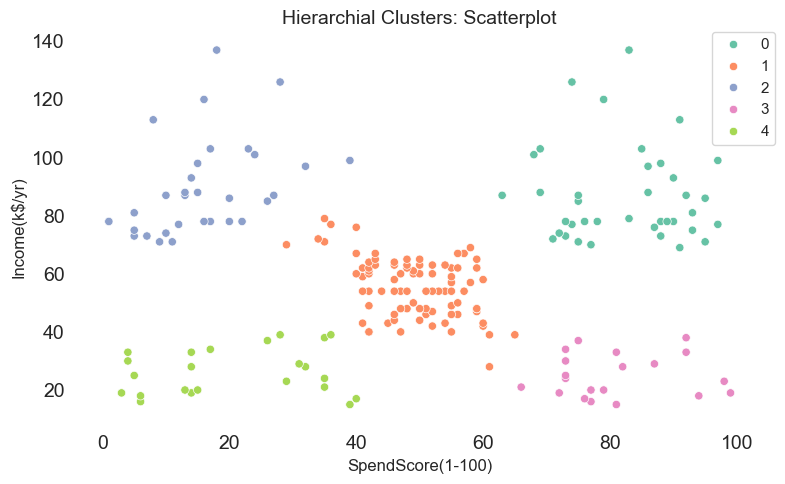

In [70]:
## visualising df with cluster through scatterplot

plt.figure(figsize=(8,5))
plt.title('Hierarchial Clusters: Scatterplot', fontsize=14)
sns.scatterplot(data=df_Hierar, x='SpendScore(1-100)',y='Income(k$/yr)',hue='Cluster', palette="Set2")
# 1의 기준 - 그림의 높이 (오른쪽상단), borderaxespad - 범레와 축 간격
plt.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.show()

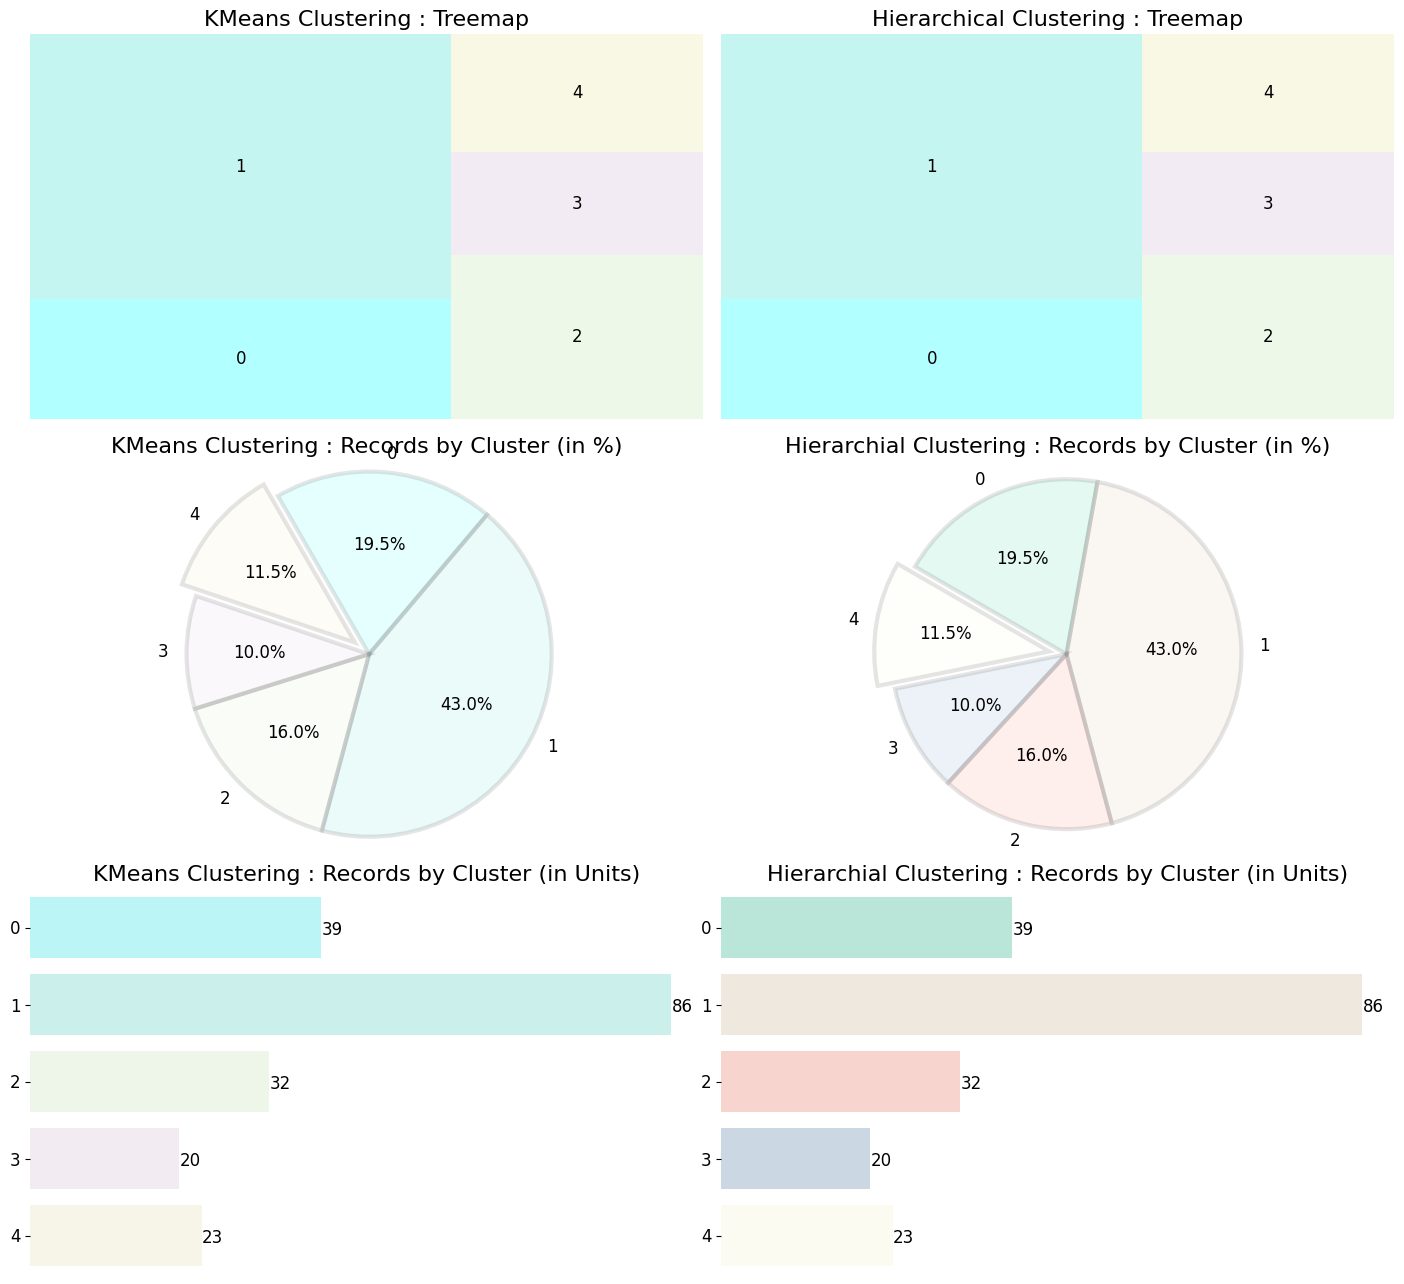

In [107]:
## Visualising the count of records by each cluster through Treemap, pie & bar charts

plt.subplots(figsize=(14,13))
my_pal = ('#00FFFF','#40E0D0', '#c7e9b4', '#D8BFD8', '#EEE8AA')
my_col = ('#00C78C', '#D2B48C', '#FF6347', '#4682B4','#FAFAD2')

plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(3,2,1)
plt.title('KMeans Clustering : Treemap', fontsize=16)

# 기존 코드에서의 수정 부분
cluster_counts = df_Kmeans['Cluster'].value_counts().reset_index()
cluster_counts = cluster_counts.sort_values(by='Cluster')

labels = cluster_counts['Cluster'].tolist()
sizes = cluster_counts['count'].tolist()

#labels = df_Kmeans['Cluster'].value_counts().index.get_level_values(0).tolist()
#sizes = df_Kmeans['Cluster'].value_counts().reset_index().Cluster.values.tolist()

squarify.plot(sizes=sizes, label=labels, color=my_pal, alpha=.3)

plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(3,2,2)
plt.title('Hierarchical Clustering : Treemap', fontsize=16)

# 기존 코드에서의 수정 부분
cluster_counts = df_Hierar['Cluster'].value_counts().reset_index()
cluster_counts = cluster_counts.sort_values(by='Cluster')

labels = cluster_counts['Cluster'].tolist()
sizes = cluster_counts['count'].tolist()

#labels = df_Hierar['Cluster'].value_counts().index.get_level_values(0).tolist()
#sizes = df_Hierar['Cluster'].value_counts().reset_index().Cluster.values.tolist()
squarify.plot(sizes=sizes, label=labels, color=my_pal, alpha=.3)
plt.axis('off')

plt.subplot(3,2,3)
my_xpl = [0.0, 0.0, 0.0, 0.0, 0.1]
plt.title('KMeans Clustering : Records by Cluster (in %)', fontsize=16)
sizes = df_Kmeans['Cluster'].value_counts().sort_index() / df_Kmeans['Cluster'].value_counts().sum()*100
labels = sizes.index
plt.pie(sizes, labels = labels, colors=my_pal, explode=my_xpl, counterclock=False, startangle=120, wedgeprops={'alpha':0.1, 'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(3,2,4)
my_xpl = [0.0, 0.0, 0.0, 0.0, 0.1]
plt.title('Hierarchial Clustering : Records by Cluster (in %)', fontsize=16)
sizes = df_Hierar['Cluster'].value_counts().sort_index() / df_Hierar['Cluster'].value_counts().sum()*100
labels = sizes.index
plt.pie(sizes, labels = labels, colors=my_col, explode=my_xpl, counterclock=False, startangle=150, wedgeprops={'alpha':0.1, 'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(3,2,5)
plt.title('KMeans Clustering : Records by Cluster (in Units)', fontsize=16)
my_ord = [0,1,2,3,4]
ax = sns.countplot(y="Cluster", data=df_Kmeans,  palette=my_pal, order=my_ord, alpha=0.3)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_width()),  (p.get_x() + p.get_width() + 0.05, p.get_y()+0.5))
plt.ylabel(None)
plt.xlabel(None)
plt.xticks([])
#plt.axis('off')
# 축 설정
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.subplot(3,2,6)
plt.title('Hierarchial Clustering : Records by Cluster (in Units)', fontsize=16)
my_ord = [0,1,2,3,4]
ax = sns.countplot(y="Cluster", data=df_Hierar, palette=my_col, order=my_ord, alpha=0.3)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_width()),  (p.get_x() + p.get_width() + 0.05, p.get_y()+0.5))
plt.ylabel(None)
plt.xlabel(None)
plt.xticks([])
#plt.axis('off')# 축 설정
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()



In [110]:
print(df_Kmeans['Cluster'].value_counts())
print(df_Hierar['Cluster'].value_counts())

Cluster
1    86
0    39
2    32
4    23
3    20
Name: count, dtype: int64
Cluster
1    86
0    39
2    32
4    23
3    20
Name: count, dtype: int64
